In [1]:
import findspark
findspark.init()

In [2]:
import pandas as pd
import re
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pickle
from pyspark.sql import SparkSession

In [42]:
spark = SparkSession.builder.appName("Capstone").config("spark.driver.maxResultSize","postgresql-42.2.16.jar").getOrCreate()

In [43]:
sc = spark.sparkContext

from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)

test_df = sqlContext.read.format("jdbc").options(url="jdbc:postgresql://capstoneprojectdb.c6vra15jaa9i.us-east-2.rds.amazonaws.com:5432/postgres",driver="org.postgresql.Driver",dbtable="chicago_airbnb_listing_dataset",user="root",password="Finalproject$")

In [44]:
database = "postgres"
table = "Chicago_Airbnb_Listing_Dataset"
user = "root"
password  = "Finalproject$"

jdbcDF = spark.read.format("jdbc") \
    .option("url", f"jdbc:postgresql://capstoneprojectdb.c6vra15jaa9i.us-east-2.rds.amazonaws.com:5432/{database}") \
    .option("dbtable", table) \
    .option("user", user) \
    .option("password", password) \
    .option("driver", "org.postgresql.Driver") \
    .load()

jdbcDF.show()

+------+----------------------+---------+----------+---------------+------------+----------------+--------+----+-----+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|    id|neighbourhood_cleansed| latitude| longitude|      room_type|accommodates|  bathrooms_text|bedrooms|beds|price|minimum_nights|maximum_nights|minimum_minimum_nights|maximum_minimum_nights|minimum_maximum_nights|maximum_maximum_nights|minimum_nights_avg_ntm|maximum_nights_avg_ntm|
+------+----------------------+---------+----------+---------------+------------+----------------+--------+----+-----+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|  2384|             Hyde Park|  41.7879|  -87.5878|   Private room|           1|   1 shared bath|       1|   1| 95.0|             3|      

In [89]:
jdbcDF2 = jdbcDF.withColumn("price",jdbcDF.price.cast('int'))
jdbcDF2 = jdbcDF2.drop(jdbcDF2.minimum_nights_avg_ntm)
jdbcDF2 = jdbcDF2.drop(jdbcDF2.maximum_nights_avg_ntm)
jdbcDF2 = jdbcDF2.drop(jdbcDF2.latitude)
jdbcDF2 = jdbcDF2.drop(jdbcDF2.longitude)
jdbcDF2 = jdbcDF2.drop(jdbcDF2.price)
jdbcDF2.dtypes

[('id', 'int'),
 ('neighbourhood_cleansed', 'string'),
 ('room_type', 'string'),
 ('accommodates', 'int'),
 ('bathrooms_text', 'string'),
 ('bedrooms', 'int'),
 ('beds', 'int'),
 ('minimum_nights', 'int'),
 ('maximum_nights', 'int'),
 ('minimum_minimum_nights', 'int'),
 ('maximum_minimum_nights', 'int'),
 ('minimum_maximum_nights', 'int'),
 ('maximum_maximum_nights', 'int')]

In [120]:
postgres_df = jdbcDF2.toPandas()

In [126]:
features_df = postgres_df.drop(["id","minimum_nights","maximum_nights","minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights"], axis=1)
features_df

,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,bedrooms,beds
0,Hyde Park,Private room,1,1 shared bath,1.0,1.0
1,West Town,Entire home/apt,2,1 bath,1.0,1.0
2,Lincoln Park,Entire home/apt,4,1 bath,2.0,2.0
3,Lincoln Park,Private room,2,1 private bath,1.0,2.0
4,West Town,Entire home/apt,4,2 baths,2.0,2.0
...,...,...,...,...,...,...
6539,West Town,Entire home/apt,2,1 bath,1.0,1.0
6540,West Town,Entire home/apt,6,1 bath,3.0,3.0
6541,Lake View,Entire home/apt,6,2 baths,2.0,2.0
6542,Lake View,Entire home/apt,6,2 baths,2.0,2.0


In [127]:
original_df = pd.read_csv('Chicago_Airbnb_Listing_Dataset.csv')
airbnb_df = original_df
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6544 entries, 0 to 6543
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6544 non-null   int64  
 1   neighbourhood_cleansed  6544 non-null   object 
 2   latitude                6544 non-null   float64
 3   longitude               6544 non-null   float64
 4   room_type               6544 non-null   object 
 5   accommodates            6544 non-null   int64  
 6   bathrooms_text          6530 non-null   object 
 7   bedrooms                5965 non-null   float64
 8   beds                    6345 non-null   float64
 9   price                   6544 non-null   object 
 10  minimum_nights          6544 non-null   int64  
 11  maximum_nights          6544 non-null   int64  
 12  minimum_minimum_nights  6544 non-null   int64  
 13  maximum_minimum_nights  6544 non-null   int64  
 14  minimum_maximum_nights  6544 non-null   

In [128]:
airbnb_df['price'] = airbnb_df['price'].str.replace('$', '')
airbnb_df['price'] = airbnb_df['price'].str.replace(',', '').astype(float)

C:\Users\Rus\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [129]:
airbnb_df.drop(airbnb_df[airbnb_df.price > 1000].index, inplace=True)

In [130]:
airbnb_df.head()

,id,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm
0,2384,Hyde Park,41.78790,-87.58780,Private room,1,1 shared bath,1.0,1.0,95.0,3,89,3,3,1125,1125,3.0,1125.0
1,7126,West Town,41.90166,-87.68021,Entire home/apt,2,1 bath,1.0,1.0,65.0,2,60,2,2,1125,1125,2.0,1125.0
2,10945,Lincoln Park,41.91196,-87.63981,Entire home/apt,4,1 bath,2.0,2.0,127.0,4,180,4,4,180,180,4.0,180.0
3,12140,Lincoln Park,41.92357,-87.64947,Private room,2,1 private bath,1.0,2.0,329.0,2,7,2,2,7,7,2.0,7.0
4,22362,West Town,41.89730,-87.65889,Entire home/apt,4,2 baths,2.0,2.0,105.0,121,1125,121,121,1125,1125,121.0,1125.0


In [131]:
neighbourhoods = airbnb_df['neighbourhood_cleansed'].value_counts()
neighbourhoods

Near North Side    749
West Town          676
Lake View          553
Near West Side     402
Logan Square       391
                  ... 
Edison Park          1
Avalon Park          1
Burnside             1
Gage Park            1
West Elsdon          1
Name: neighbourhood_cleansed, Length: 76, dtype: int64

In [132]:
neighbourhood_list = neighbourhoods.index
neighbourhood_list
neighbourhood_num = np.arange(len(neighbourhood_list))

In [133]:
room_type_list = airbnb_df['room_type'].value_counts().index
accommodates_list = airbnb_df['accommodates'].value_counts().index
bathroom_list = airbnb_df['bathrooms_text'].value_counts().index
bedroom_list = airbnb_df['bedrooms'].value_counts().index
beds_list = airbnb_df['beds'].value_counts().index

In [134]:
neighbourhood_list

Index(['Near North Side', 'West Town', 'Lake View', 'Near West Side',
       'Logan Square', 'Loop', 'Lincoln Park', 'Uptown', 'Near South Side',
       'Lower West Side', 'Irving Park', 'Edgewater', 'Bridgeport', 'Avondale',
       'Rogers Park', 'North Center', 'East Garfield Park', 'Grand Boulevard',
       'Hyde Park', 'Lincoln Square', 'South Shore', 'Humboldt Park',
       'West Ridge', 'Woodlawn', 'Portage Park', 'Douglas', 'Albany Park',
       'Kenwood', 'Armour Square', 'Austin', 'Greater Grand Crossing',
       'South Lawndale', 'Jefferson Park', 'Washington Park', 'North Lawndale',
       'Mckinley Park', 'Norwood Park', 'Dunning', 'Calumet Heights',
       'South Chicago', 'West Garfield Park', 'Belmont Cragin',
       'Brighton Park', 'North Park', 'Hermosa', 'Englewood', 'New City',
       'Oakland', 'Garfield Ridge', 'Chatham', 'Auburn Gresham', 'Ohare',
       'Ashburn', 'Pullman', 'East Side', 'Forest Glen', 'Washington Heights',
       'Roseland', 'West Englewood', '

In [14]:
# neighborhood_dict = dict(zip(neighbourhood_list,neighbourhood_num))
neighborhood_dict = dict(zip(neighbourhoods.index,np.arange(len(neighbourhoods.index))))
neighborhood_dict

{'Near North Side': 0,
 'West Town': 1,
 'Lake View': 2,
 'Near West Side': 3,
 'Logan Square': 4,
 'Loop': 5,
 'Lincoln Park': 6,
 'Uptown': 7,
 'Near South Side': 8,
 'Lower West Side': 9,
 'Irving Park': 10,
 'Edgewater': 11,
 'Bridgeport': 12,
 'Avondale': 13,
 'Rogers Park': 14,
 'North Center': 15,
 'East Garfield Park': 16,
 'Grand Boulevard': 17,
 'Hyde Park': 18,
 'Lincoln Square': 19,
 'South Shore': 20,
 'Humboldt Park': 21,
 'West Ridge': 22,
 'Woodlawn': 23,
 'Portage Park': 24,
 'Douglas': 25,
 'Albany Park': 26,
 'Kenwood': 27,
 'Armour Square': 28,
 'Austin': 29,
 'Greater Grand Crossing': 30,
 'South Lawndale': 31,
 'Jefferson Park': 32,
 'Washington Park': 33,
 'North Lawndale': 34,
 'Mckinley Park': 35,
 'Norwood Park': 36,
 'Dunning': 37,
 'Calumet Heights': 38,
 'South Chicago': 39,
 'West Garfield Park': 40,
 'Belmont Cragin': 41,
 'Brighton Park': 42,
 'North Park': 43,
 'Hermosa': 44,
 'Englewood': 45,
 'New City': 46,
 'Oakland': 47,
 'Garfield Ridge': 48,
 'Ch

In [15]:
cleaning_df = airbnb_df
cleaning_df['neighbourhood_cleansed'] = cleaning_df['neighbourhood_cleansed'].apply(lambda x:neighborhood_dict[x])
cleaning_df.head()

,id,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm
0,2384,18,41.78790,-87.58780,Private room,1,1 shared bath,1.0,1.0,95.0,3,89,3,3,1125,1125,3.0,1125.0
1,7126,1,41.90166,-87.68021,Entire home/apt,2,1 bath,1.0,1.0,65.0,2,60,2,2,1125,1125,2.0,1125.0
2,10945,6,41.91196,-87.63981,Entire home/apt,4,1 bath,2.0,2.0,127.0,4,180,4,4,180,180,4.0,180.0
3,12140,6,41.92357,-87.64947,Private room,2,1 private bath,1.0,2.0,329.0,2,7,2,2,7,7,2.0,7.0
4,22362,1,41.89730,-87.65889,Entire home/apt,4,2 baths,2.0,2.0,105.0,121,1125,121,121,1125,1125,121.0,1125.0


In [16]:
# airbnb_df['bathrooms_text'] = airbnb_df['bathrooms_text'].str.replace(' shared bath', '')
cleaning_df['bathrooms_text'].value_counts()

1 bath               3296
2 baths               968
1 shared bath         738
1 private bath        451
2 shared baths        202
1.5 baths             187
2.5 baths             157
1.5 shared baths      108
3 baths               108
3.5 baths              66
4 baths                36
3 shared baths         33
2.5 shared baths       32
4 shared baths         19
4.5 baths              15
0 shared baths          9
0 baths                 5
6 baths                 5
11 shared baths         4
5 baths                 4
Private half-bath       3
Shared half-bath        3
7 baths                 2
Half-bath               2
11.5 shared baths       1
6.5 baths               1
8 shared baths          1
12.5 baths              1
Name: bathrooms_text, dtype: int64

In [17]:
cleaning_df['bathrooms_text'] = cleaning_df['bathrooms_text'].str.replace('-bath', '0.5')
cleaning_df['bathrooms_text'] = cleaning_df['bathrooms_text'].str.extract('(\d*\.\d+|\d+)', expand=False)
cleaning_df['bathrooms_text'] = cleaning_df['bathrooms_text'].astype(float)
cleaning_df = cleaning_df.dropna()

In [18]:
# working_df = pd.get_dummies(cleaning_df)
working_df = cleaning_df.drop(['price','id','latitude','longitude','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'minimum_nights', 'maximum_nights'], axis=1)
working_df

,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,bedrooms,beds
0,18,Private room,1,1.0,1.0,1.0
1,1,Entire home/apt,2,1.0,1.0,1.0
2,6,Entire home/apt,4,1.0,2.0,2.0
3,6,Private room,2,1.0,1.0,2.0
4,1,Entire home/apt,4,2.0,2.0,2.0
...,...,...,...,...,...,...
6539,1,Entire home/apt,2,1.0,1.0,1.0
6540,1,Entire home/apt,6,1.0,3.0,3.0
6541,2,Entire home/apt,6,2.0,2.0,2.0
6542,2,Entire home/apt,6,2.0,2.0,2.0


In [19]:
X = pd.get_dummies(working_df)
y = cleaning_df['price']
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5739 entries, 0 to 6543
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   neighbourhood_cleansed     5739 non-null   int32  
 1   accommodates               5739 non-null   int64  
 2   bathrooms_text             5739 non-null   float64
 3   bedrooms                   5739 non-null   float64
 4   beds                       5739 non-null   float64
 5   room_type_Entire home/apt  5739 non-null   uint8  
 6   room_type_Hotel room       5739 non-null   uint8  
 7   room_type_Private room     5739 non-null   uint8  
 8   room_type_Shared room      5739 non-null   uint8  
dtypes: float64(3), int32(1), int64(1), uint8(4)
memory usage: 269.0 KB


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=3)

In [22]:
# Fit the model on training data
model.fit(X_train_scaled, y_train)
        
# Predict results
y_test_preds = model.predict(X_test_scaled) 

# Evaluate the result
rsquared_score = r2_score(y_test, y_test_preds)
print('R sequared = ', rsquared_score)

R sequared =  0.4702645502163091


In [23]:
number_input_features = 9 #len(X_train[0])
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation=None))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                800       
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,261
Trainable params: 3,261
Non-trainable params: 0
_________________________________________________________________


In [24]:
nn.compile(loss="mean_absolute_error", optimizer="adam")

In [25]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,validation_split=0.1)

Epoch 1/100
122/122 [==============================] - 1s 2ms/step - loss: 143.5433 - val_loss: 127.8897
Epoch 2/100
122/122 [==============================] - 0s 1ms/step - loss: 90.4762 - val_loss: 70.4217
Epoch 3/100
122/122 [==============================] - 0s 948us/step - loss: 64.6207 - val_loss: 65.1990
Epoch 4/100
122/122 [==============================] - 0s 940us/step - loss: 61.5141 - val_loss: 63.3334
Epoch 5/100
122/122 [==============================] - 0s 1ms/step - loss: 60.2608 - val_loss: 61.9589
Epoch 6/100
122/122 [==============================] - 0s 1ms/step - loss: 59.3565 - val_loss: 60.7780
Epoch 7/100
122/122 [==============================] - 0s 1ms/step - loss: 58.6537 - val_loss: 59.7777
Epoch 8/100
122/122 [==============================] - 0s 1ms/step - loss: 58.0925 - val_loss: 59.0510
Epoch 9/100
122/122 [==============================] - 0s 1ms/step - loss: 57.7127 - val_loss: 58.5257
Epoch 10/100
122/122 [==============================] - 0s 1ms/step

In [135]:
# price_bins = [0.0, 49.0, 99.0, 149.0, 199.0, 249.0, 299.0, 
#               349.0, 399.0, 449.0, 499.0, 549.0, 
#               599.0, 649.0, 699.0, 749.0, 799.0,
#              849.0, 899.0, 949.0, 999.0, 1000.0]

# price_labels = ['0-49','50-99','100-149', '150-199', '200-249', '250-299', '300-349', '350-399','400-449', '450-499',
#              '500-549', '550-599', '600-649', '650-699', '700-749', '750-799', '800-849', '850-899', '900-949', '950-999', 
#              '1000+']

# price_bins = [0.0, 99.0, 199.0, 299.0,
#               399.0, 499.0, 599.0, 699.0, 799.0, 
#               899.0, 999.0, 1000.0]

# price_labels = ['0-99','100-199', '200-299', '300-399','400-499',
#              '500-599', '600-699','700-799', '800-899', '900-999', 
#              '1000+']

price_bins = [0.0, 49.0, 74.0, 99.0, 124.0, 149.0, 199.0, 299.0, 100000.0]

price_labels = ['0-49','50-74','75-99','100-124','125-149','150-199', '200-299', '300+']

In [137]:
class_airbnb_df = pd.read_csv('Chicago_Airbnb_Listing_Dataset.csv')
class_airbnb_df['price'] = class_airbnb_df['price'].str.replace('$', '')
class_airbnb_df['price'] = class_airbnb_df['price'].str.replace(',', '').astype(float)
class_airbnb_df['bathrooms_text'] = class_airbnb_df['bathrooms_text'].str.replace('-bath', '0.5')
class_airbnb_df['bathrooms_text'] = class_airbnb_df['bathrooms_text'].str.extract('(\d*\.\d+|\d+)', expand=False)
class_airbnb_df['bathrooms_text'] = class_airbnb_df['bathrooms_text'].astype(float)
class_airbnb_df["price_range"] = pd.cut(class_airbnb_df["price"], price_bins, labels=price_labels)

C:\Users\Rus\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [140]:
counts = class_airbnb_df["price_range"].value_counts()
counts

75-99      1055
150-199     902
50-74       890
100-124     864
0-49        814
200-299     723
125-149     667
300+        627
Name: price_range, dtype: int64

In [28]:
RFC_df = class_airbnb_df
RFC_df = RFC_df.dropna()
class_df = RFC_df.drop(['price','price_range','id','minimum_minimum_nights',
                           'maximum_minimum_nights', 'minimum_maximum_nights','maximum_maximum_nights',
                           'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'minimum_nights','maximum_nights'], axis=1)
X_class = pd.get_dummies(class_df)
# X_class['room_type']  = LabelEncoder().fit_transform(X_class['room_type'])
y_class = LabelEncoder().fit_transform(RFC_df['price_range'])

In [30]:
X_class.head()

,latitude,longitude,accommodates,bathrooms_text,bedrooms,beds,neighbourhood_cleansed_Albany Park,neighbourhood_cleansed_Archer Heights,neighbourhood_cleansed_Armour Square,neighbourhood_cleansed_Ashburn,...,neighbourhood_cleansed_West Garfield Park,neighbourhood_cleansed_West Lawn,neighbourhood_cleansed_West Pullman,neighbourhood_cleansed_West Ridge,neighbourhood_cleansed_West Town,neighbourhood_cleansed_Woodlawn,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,41.78790,-87.58780,1,1.0,1.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,41.90166,-87.68021,2,1.0,1.0,1.0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,41.91196,-87.63981,4,1.0,2.0,2.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,41.92357,-87.64947,2,1.0,1.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,41.89730,-87.65889,4,2.0,2.0,2.0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [31]:
# Split Data to test and train
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, random_state=1)

#Scale data
scaler = MinMaxScaler().fit(X_train_class)
X_train_scaled = scaler.transform(X_train_class)
X_test_scaled = scaler.transform(X_test_class)

In [32]:
clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=3).fit(X_train_scaled, y_train_class)

In [33]:
print(f'Training Score: {clf.score(X_train_scaled, y_train_class)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test_class)}')

Training Score: 0.3499884872208151
Testing Score: 0.337707182320442


In [34]:
prediction = clf.predict([X_test_scaled[1]])
prediction

array([7])

In [35]:
print([X_test_scaled[1]])

[array([0.67185375, 0.49163557, 0.2       , 0.08      , 0.09090909,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.    

In [36]:
pred_val = prediction.tolist()

In [37]:
number_input_features_x = 86
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 30

nn_class = tf.keras.models.Sequential()

# First hidden layer
nn_class.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features_x, activation="relu"))

# Second hidden layer
nn_class.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

nn_class.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn_class.add(tf.keras.layers.Dense(units=8, activation='sigmoid'))

# Check the structure of the model
nn_class.summary()

nn_class.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
#     epsilon=1e-07,
    name='Adam'
), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 80)                6960      
                                                                 
 dense_4 (Dense)             (None, 30)                2430      
                                                                 
 dense_5 (Dense)             (None, 30)                930       
                                                                 
 dense_6 (Dense)             (None, 8)                 248       
                                                                 
Total params: 10,568
Trainable params: 10,568
Non-trainable params: 0
_________________________________________________________________


In [38]:
y_reshape = y_train_class.reshape(-1,1)
y_reshape_test = y_test_class.reshape(-1,1)
y_nn_enc = OneHotEncoder().fit(y_reshape)
y_train_nn = y_nn_enc.transform(y_reshape).toarray()
y_test_nn = y_nn_enc.transform(y_reshape_test).toarray()

In [39]:
fit_class = nn_class.fit(X_train_scaled,y_train_nn,epochs=100,validation_split=0.1)

Epoch 1/100
123/123 [==============================] - 1s 2ms/step - loss: 2.0687 - accuracy: 0.1855 - val_loss: 2.0602 - val_accuracy: 0.2161
Epoch 2/100
123/123 [==============================] - 0s 1ms/step - loss: 2.0451 - accuracy: 0.2285 - val_loss: 2.0359 - val_accuracy: 0.2460
Epoch 3/100
123/123 [==============================] - 0s 1ms/step - loss: 2.0122 - accuracy: 0.2487 - val_loss: 2.0010 - val_accuracy: 0.2644
Epoch 4/100
123/123 [==============================] - 0s 1ms/step - loss: 1.9682 - accuracy: 0.2697 - val_loss: 1.9537 - val_accuracy: 0.2736
Epoch 5/100
123/123 [==============================] - 0s 1ms/step - loss: 1.9184 - accuracy: 0.2789 - val_loss: 1.9047 - val_accuracy: 0.2759
Epoch 6/100
123/123 [==============================] - 0s 1ms/step - loss: 1.8739 - accuracy: 0.2843 - val_loss: 1.8640 - val_accuracy: 0.2989
Epoch 7/100
123/123 [==============================] - 0s 1ms/step - loss: 1.8370 - accuracy: 0.3017 - val_loss: 1.8333 - val_accuracy: 0.3034

Epoch 58/100
123/123 [==============================] - 0s 1ms/step - loss: 1.5252 - accuracy: 0.3767 - val_loss: 1.5217 - val_accuracy: 0.4023
Epoch 59/100
123/123 [==============================] - 0s 1ms/step - loss: 1.5245 - accuracy: 0.3759 - val_loss: 1.5218 - val_accuracy: 0.4023
Epoch 60/100
123/123 [==============================] - 0s 1ms/step - loss: 1.5235 - accuracy: 0.3790 - val_loss: 1.5199 - val_accuracy: 0.4023
Epoch 61/100
123/123 [==============================] - 0s 1ms/step - loss: 1.5219 - accuracy: 0.3782 - val_loss: 1.5191 - val_accuracy: 0.4069
Epoch 62/100
123/123 [==============================] - 0s 1ms/step - loss: 1.5210 - accuracy: 0.3787 - val_loss: 1.5203 - val_accuracy: 0.4069
Epoch 63/100
123/123 [==============================] - 0s 1ms/step - loss: 1.5202 - accuracy: 0.3841 - val_loss: 1.5192 - val_accuracy: 0.4138
Epoch 64/100
123/123 [==============================] - 0s 1ms/step - loss: 1.5200 - accuracy: 0.3802 - val_loss: 1.5178 - val_accuracy:

In [40]:
nn_class.evaluate(x=X_test_scaled,y=y_test_nn)

46/46 [==============================] - 0s 931us/step - loss: 1.5717 - accuracy: 0.3681


[1.5717179775238037, 0.36809390783309937]

In [50]:

pickle_out = open("RFC_Model","wb")
pickle.dump(clf, pickle_out)
pickle_out.close()

In [51]:
new_RF = pickle.load(open("RFC_Model","rb"))

In [52]:
new_RF.score(X_test_scaled, y_test_class)

0.337707182320442

In [53]:
nn_class.save("NN_TF_Model.h5")

In [54]:
new_model = tf.keras.models.load_model("NN_TF_Model.h5")

In [55]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 80)                6960      
                                                                 
 dense_4 (Dense)             (None, 30)                2430      
                                                                 
 dense_5 (Dense)             (None, 30)                930       
                                                                 
 dense_6 (Dense)             (None, 8)                 248       
                                                                 
Total params: 10,568
Trainable params: 10,568
Non-trainable params: 0
_________________________________________________________________


In [56]:
new_model.evaluate(x=X_test_scaled,y=y_test_nn)

46/46 [==============================] - 0s 831us/step - loss: 1.5717 - accuracy: 0.3681


[1.5717179775238037, 0.36809390783309937]

In [6]:
def clean_listings(df):
    
    # Convert price type from string to float and remove $ sign and commas
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '').astype(float)
    df.drop(df[df.price > 1000].index, inplace=True)

    #Convert neighborhood name to a numerical number
    neighbourhoods = airbnb_df['neighbourhood_cleansed'].value_counts()
    neighborhood_dict = dict(zip(neighbourhoods.index,np.arange(len(neighbourhoods.index))))
    df['neighbourhood_cleansed'] = df['neighbourhood_cleansed'].apply(lambda x:neighborhood_dict[x])

    price_bins = [0.0, 49.0, 74.0, 99.0, 124.0, 149.0, 199.0, 299.0, 100000.0]
    price_labels = ['0-49','50-74','75-99','100-124','125-149','150-199', '200-299', '300+']
     
    #Convert Bathrooms from String to Float
    df['bathrooms_text'] = df['bathrooms_text'].str.replace('-bath', '0.5')
    df['bathrooms_text'] = df['bathrooms_text'].str.extract('(\d*\.\d+|\d+)', expand=False)
    df['bathrooms_text'] = df['bathrooms_text'].astype(float)    
    df["price_range"] = pd.cut(df["price"], price_bins, labels=price_labels)
    df.dropna()


    # Drop row that are not needed
    df.drop(['id','latitude','longitude','minimum_minimum_nights','maximum_minimum_nights',
            'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
            'maximum_nights_avg_ntm', 'minimum_nights', 'maximum_nights'], axis=1, inplace=True)
    return df

test_df = clean_listings(original_df.copy())
test_df.head()

C:\Users\Rus\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,bedrooms,beds,price,price_range
0,18,Private room,1,1.0,1.0,1.0,95.0,75-99
1,1,Entire home/apt,2,1.0,1.0,1.0,65.0,50-74
2,6,Entire home/apt,4,1.0,2.0,2.0,127.0,125-149
3,6,Private room,2,1.0,1.0,2.0,329.0,300+
4,1,Entire home/apt,4,2.0,2.0,2.0,105.0,100-124


In [47]:
def feature_plot(importances, X_train_class, y_train_class):
    
    headers = ["feature", "score"]
    values = sorted(zip(X_train_class.columns, model.feature_importances_), key=lambda x: x[1] * -1)
    feature_importances = pd.DataFrame(values, columns = headers)
    feature_importances = feature_importances.sort_values(by = ['score'], ascending = False)

    features = feature_importances['feature'][:10]
    y_pos = np.arange(len(features))
    scores = feature_importances['score'][:10]

    #plot feature importances
    plt.figure(figsize=(15,8))
    plt.bar(y_pos, scores, align='center')
    plt.xticks(y_pos, features, rotation='vertical')
    plt.ylabel('Score')
    plt.xlabel('Features')
    plt.title('Feature importances (Chicago Price of Airbnb)');

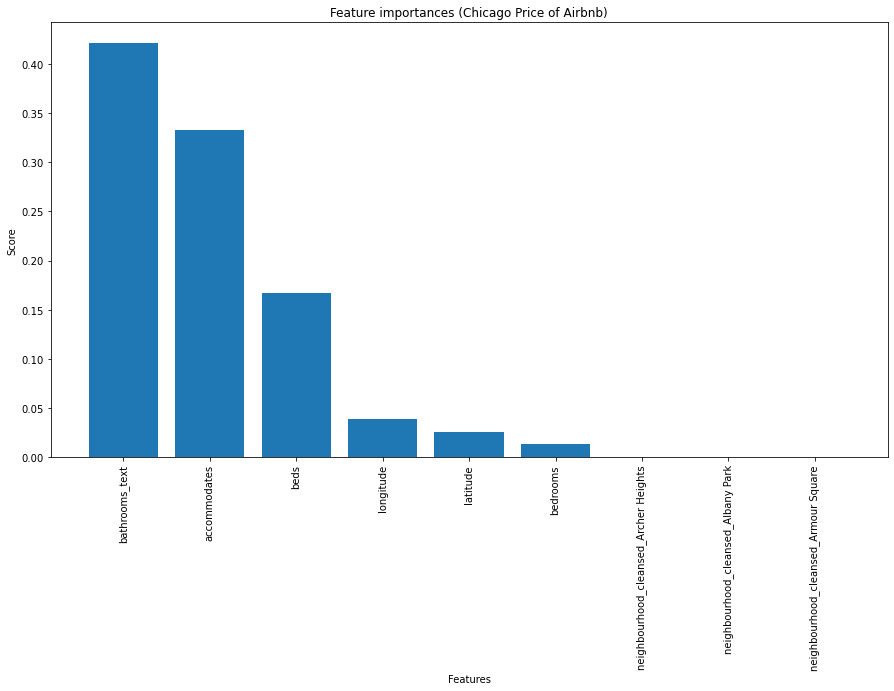

In [58]:
importances = clf.feature_importances_
feature_plot(importances, X_train_class, y_train_class)